# EcoFOCIpy PostQC example to update netcdf file

see [EcoFOCIpy_sbe_UAF.ipynb](EcoFOCIpy_sbe_UAF.ipynb) for initial processing and formatting.  Data would have been convertted from raw instrument format to csv files, initial dirty plots created and a meta-data rich and meta-data poor dataset would have been created.  The metadata poor csv file is used for the initial preliminary data archive, the metadata rich netcdf file is used for QC procedures and eventual final data archive.

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

- **TODO** Programmatically simplify following tools

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import pandas as pd
import xarray as xr
import datetime
import EcoFOCIpy.io.erddap as erddap

import EcoFOCIpy.metaconfig.load_config as load_config

In [4]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2022/Moorings/22ckp12a/working/'
filename = '22ckp12a_an9_0054m.nc'

### Post Manual QC load data and rebuild nc file

- using excel for a few points or a dynamic web map for multiple (a tool on ecofoci-field.pmel.noaa.gov) or any other method to identify spikes
- remove values above 32psu and below 30psu

**NOTE** if you use excel, be cautious about how your time is formatted (its important) - use custom formatting and make it of the form `yyyy-mm-ddTHH:MM:SSZ` to assure proper read in to xarray

*TODO:* use erddap hosted data 

In [5]:
# this loads the initial working netcdf file
wop_nc_qc = xr.load_dataset(user_data_dir+filename)

In [6]:
wop_nc_qc

<xarray.Dataset>
Dimensions:         (time: 2945, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time            (time) datetime64[ns] 2022-10-24 ... 2023-02-23T16:00:00
  * latitude        (latitude) float64 67.91
  * longitude       (longitude) float64 -168.2
  * depth           (depth) float64 54.5
Data variables:
    current_speed   (time, depth, latitude, longitude) float64 14.67 ... 37.84
    u_curr_comp     (time, depth, latitude, longitude) float64 -8.125 ... -22.85
    v_curr_comp     (time, depth, latitude, longitude) float64 12.21 ... 30.15
    oxy_conc        (time, depth, latitude, longitude) float64 nan ... 329.5
    oxy_percentsat  (time, depth, latitude, longitude) float64 nan ... 88.81
    temperature     (time, depth, latitude, longitude) float64 2.965 ... -1.812
    pressure        (time, depth, latitude, longitude) float64 54.81 ... 54.81
    oxy_conc_umkg   (time, depth, latitude, longitude) float64 nan ... 321.0
Attributes: (12/33)
    Latitude_DegMMddW:                      67 54.621 N
    Longitude_DegMMddN:                     168 11.056 W
    MooringID:                              22CKP-12A
    platform_deployment_date:               2022-10-23T00:00:00Z
    platform_deployment_cruise_name:        SKQ2022-14S
    platform_recovery_date:                 2023-10-02T00:22:00Z
    ...                                     ...
    InstrumentSerialNumber:                 645
    InstrumentType:                         RCM9
    date_created:                           2025-02-18T12:45:56Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

In [7]:
# this reads the previous csv and assumes you've made modifications to the content but not the structure (record length or variable names)
df_qc = pd.read_csv(user_data_dir+filename.replace('nc','to_edit.csv'), index_col=['time','depth','latitude','longitude']) #order is important

In [8]:
df_qc

,,,,current_speed,u_curr_comp,v_curr_comp,oxy_conc,oxy_percentsat,temperature,pressure,oxy_conc_umkg
time,depth,latitude,longitude,,,,,,,,
2022-10-24T00:00:00Z,54.5,67.91035,-168.184267,14.6650,-8.124789,12.208604,NaN,NaN,2.965370,54.812403,NaN
2022-10-24T01:00:00Z,54.5,67.91035,-168.184267,12.9052,-3.799632,12.333166,NaN,NaN,2.496727,54.812403,NaN
2022-10-24T02:00:00Z,54.5,67.91035,-168.184267,14.0784,-2.721888,13.812772,NaN,NaN,2.356004,54.812403,NaN
2022-10-24T03:00:00Z,54.5,67.91035,-168.184267,14.0784,-2.296979,13.889753,NaN,NaN,2.309082,54.812403,NaN
2022-10-24T04:00:00Z,54.5,67.91035,-168.184267,17.5980,-2.551213,17.412091,NaN,NaN,2.285618,54.812403,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-23T12:00:00Z,54.5,67.91035,-168.184267,32.2630,-17.874536,26.858930,NaN,NaN,-1.811880,54.812403,NaN
2023-02-23T13:00:00Z,54.5,67.91035,-168.184267,31.9697,-18.359751,26.172147,NaN,NaN,-1.811880,54.812403,NaN
2023-02-23T14:00:00Z,54.5,67.91035,-168.184267,34.6094,-19.875694,28.333150,NaN,NaN,-1.811880,54.812403,NaN


In [9]:
#replace original data with editied data
for var in wop_nc_qc.variables:
    if var not in ['time','latitude','longitude','depth'] + []:
        print(var)
        try:
            wop_nc_qc[var].values=xr.Dataset.from_dataframe(df_qc)[var]
            print(f'{var} success')
        except:
            pass

current_speed
current_speed success
u_curr_comp
u_curr_comp success
v_curr_comp
v_curr_comp success
oxy_conc
oxy_conc success
oxy_percentsat
oxy_percentsat success
temperature
temperature success
pressure
pressure success
oxy_conc_umkg
oxy_conc_umkg success


In [10]:
#drop oxy conc for oxygen
# wop_nc_qc = wop_nc_qc.drop('oxy_conc')

### Update global attributes

In [11]:
wop_nc_qc.attrs.update({'QC_indicator': 'ProbablyGood'})
try:
    wop_nc_qc.attrs.update({'history':(wop_nc_qc.history + "\nQC'd: "+ str(datetime.datetime.today()))})
except:
    pass

In [12]:
wop_nc_qc.attrs.update({'date_modified':str(datetime.datetime.today())})

In [13]:
wop_nc_qc.to_netcdf(user_data_dir+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})

/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_68328/664318075.py:1: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'hours' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  wop_nc_qc.to_netcdf(user_data_dir+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})


## Plot against CTD if necessary

In [12]:
import pandas as pd
import EcoFOCIpy.io.erddap as erddap

url = "http://ecofoci-field.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [28]:
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2103',qclevel='final',concastno='027')
reccast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2206',qclevel='final',concastno='022')

In [29]:
depcast.columns = [x.split(' ')[0] for x in depcast.columns]
reccast.columns = [x.split(' ')[0] for x in reccast.columns]

In [30]:
depcast.pressure = depcast.pressure.round()
reccast.pressure = reccast.pressure.round()

some variable names switch between preliminary and final... this will eventually be resolved

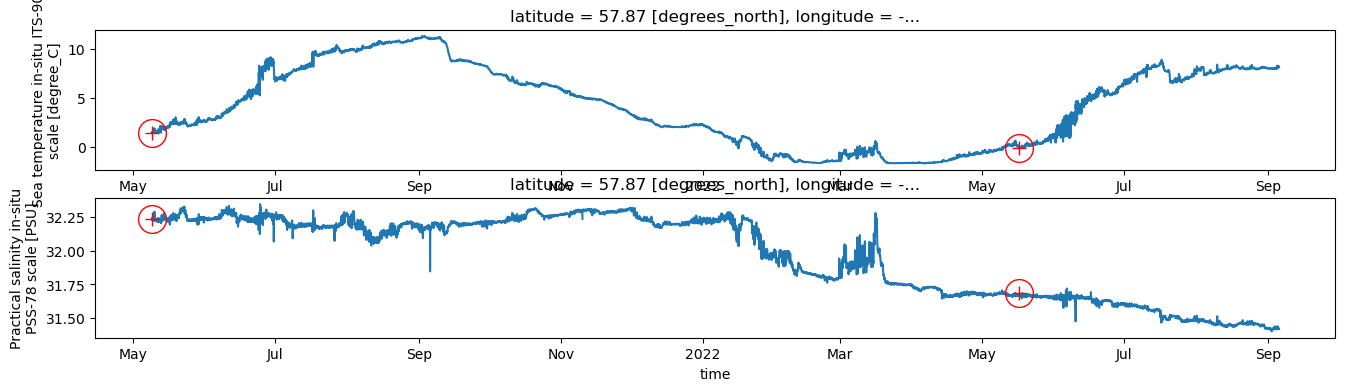

In [35]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
# depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])
depth = 39

fig, ax = plt.subplots(2,figsize=(16, 4))
wop_nc_qc.temperature.plot(x="time",hue="depth",ax=ax[0], add_legend=False);
# wop_nc_qc.oxy_temperature.plot(x="time",hue="depth",ax=ax[0], add_legend=False);
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['temperature_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['temperature_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax[0].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['temperature_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[0].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['temperature_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

wop_nc_qc.salinity.plot(x="time",hue="depth",ax=ax[1], add_legend=False);
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['salinity_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['salinity_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax[1].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['salinity_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[1].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['salinity_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

